In [38]:
import pandas as pd
import nasdaqdatalink
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import coint
from statsmodels.regression.rolling import RollingOLS
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm


nasdaqdatalink.ApiConfig.api_key = 'zxLNKQydu_qNXQ2tZ7vz'

etf_symbols = ["VCSH", "HYG"]

# etf_symbols = [
#     "SPY", "IVV", "VOO", "VTI", "QQQ", "VEA", "BND", "VTV", "IEFA", "VUG",
#     "AGG", "IWF", "VWO", "IEMG", "IJH", "VIG", "IJR", "VXUS", "GLD", "VGT",
#     "VO", "BNDX", "XLK", "IWM", "IWD", "SCHD", "VYM", "EFA", "ITOT", "TLT",
#     "VB", "RSP", "BIL", "XLV", "VCIT", "XLE", "MUB", "IVW", "VCSH", "VEU",
#     "QUAL", "SCHX", "BSV", "SCHF", "IXUS", "LQD", "IWB", "VTEB", "JEPI", "VNQ",
#     "XLF", "VT", "DIA", "VV", "USMV", "IEF", "SHY", "MBB", "IWR", "IAU",
#     "IVE", "DGRO", "VBR", "GOVT", "SCHB", "JPST", "VGSH", "IUSB", "SPLG", "DFAC",
#     "IGSB", "SHV", "VGIT", "SCHG", "TIP", "SPYG", "SDY", "USFR", "SGOV", "MDY",
#     "ACWI", "DVY", "TQQQ", "VMBS", "VGK", "SPYV", "EEM", "XLY", "EFV", "SPDW",
#     "COWZ", "VHT", "BIV", "XLP", "QQQM", "VONG", "HYG", "MGK", "VXF", "VOE"
# ]

In [39]:
# Initialize an empty DataFrame for combined prices
combined_prices_df = pd.DataFrame()

# Iterate over each ETF in your universe
for ticker in etf_symbols:
    # Fetch the data
    prices = nasdaqdatalink.get_table('SHARADAR/SFP', qopts={"columns":['date', 'closeadj']}, date={'gte':'2022-11-13'}, ticker=ticker)
    
    # Create DataFrame and calculate log returns
    prices_df = pd.DataFrame(prices[::-1])
    prices_df.set_index('date', inplace=True)  # Set 'date' as index

    # Add this ETF's adjusted close prices to the combined DataFrame
    combined_prices_df[ticker] = prices_df['closeadj']

# Drop rows with any NaN values to ensure all series are aligned
combined_prices_df.dropna(inplace=True)

combined_prices_df.to_csv("etf.csv", index=True)


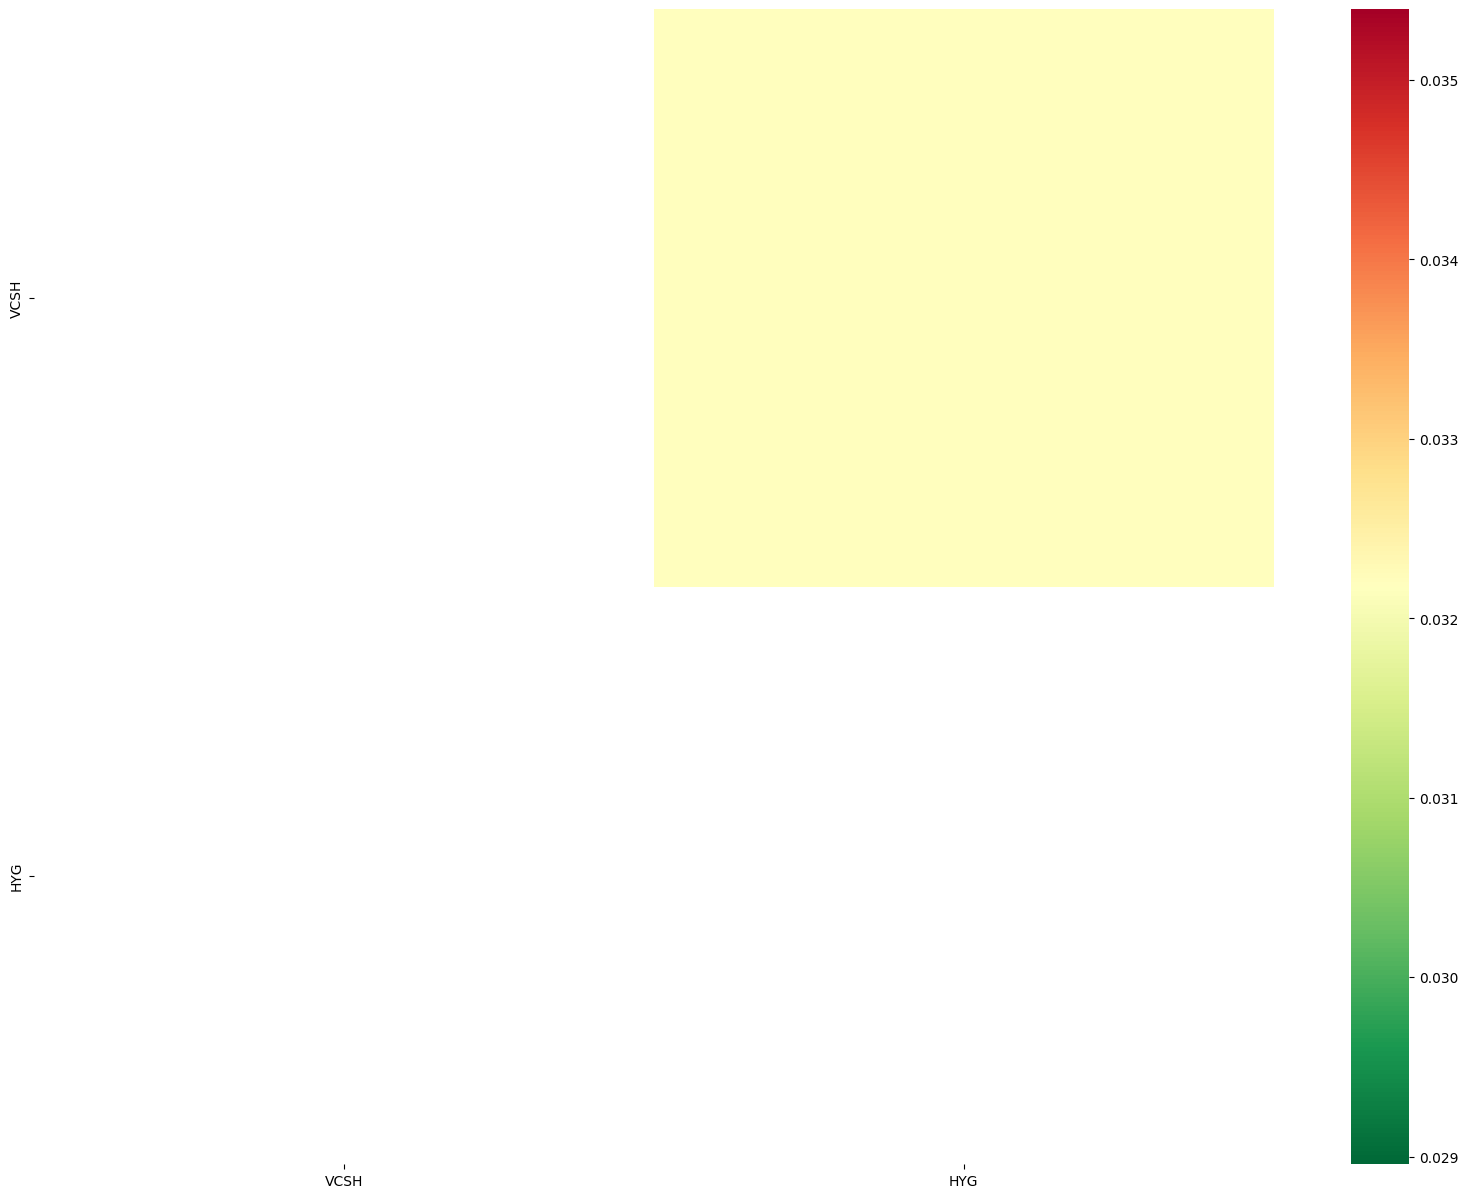

[('VCSH', 'HYG')]


In [40]:
def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.columns
    pairs = []

    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]

            if len(S1) != len(S2):
                print(f"Mismatch for pairs: {keys[i]} and {keys[j]}")
                continue

            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs


# Assuming combined_prices_df is already defined and structured correctly
scores, pvalues, pairs = find_cointegrated_pairs(combined_prices_df)


# Adjust the figure size
plt.figure(figsize=(20, 15))

# Plotting the heatmap
sns.heatmap(pvalues, xticklabels=combined_prices_df.columns, yticklabels=combined_prices_df.columns, cmap='RdYlGn_r', mask=(pvalues >= 0.05))

# Display the plot
plt.show()

print(pairs)

### Set Algorithm Params

In [41]:
# Algorithm Params
lookback_window = 60 # used for regression
zscore_window = 30 # used for zscore calculation, must be less than lookback_window

upper_threshold = 2
lower_threshold = -2
symbol_one = "VCSH"
symbol_two = "HYG"


### Data Fetching

In [42]:
# Here we can either get fresh data or use combined 

selected_pair = combined_prices_df[[symbol_one, symbol_two]]



### Calculate Spread, Z-Score

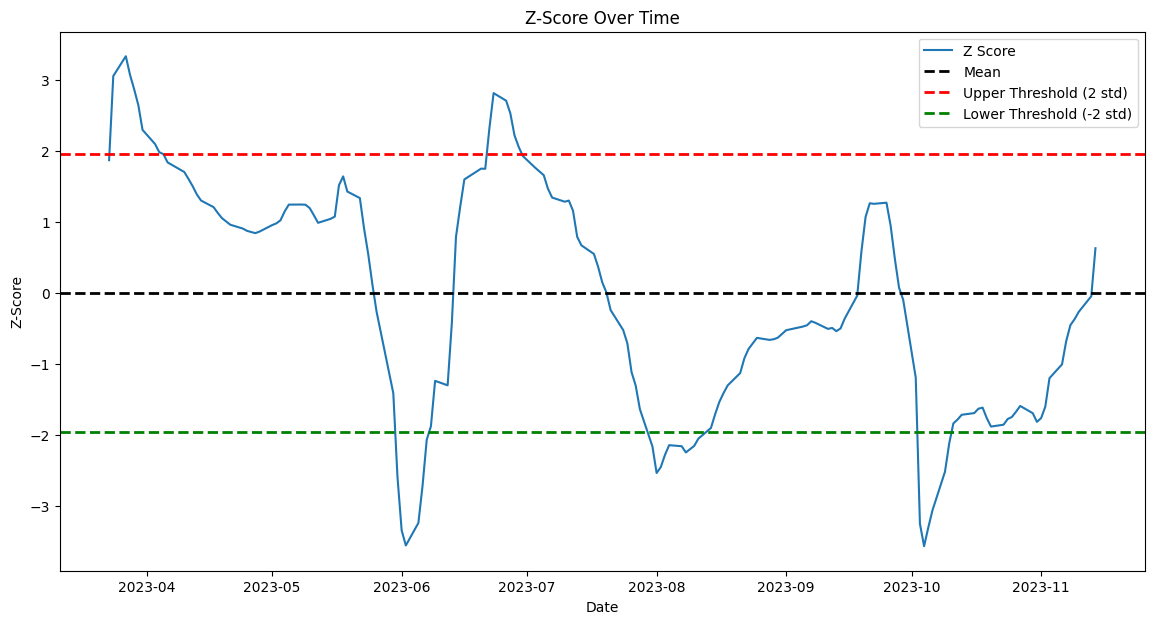

In [43]:
def rolling_hedge_ratio(Y, X, window_size):
    # Add a constant to X to represent the intercept for the OLS regression
    X_with_const = sm.add_constant(X)

    # Initialize the hedge_ratios Series to store the results
    hedge_ratios = pd.Series(index=Y.index)

    # Perform the rolling regression and calculate the hedge ratio (beta coefficient)
    rolling_model = RollingOLS(Y, X_with_const, window=window_size)
    rolling_results = rolling_model.fit()

    # Extract the beta coefficients (hedge ratios) from the rolling regression results
    # Use 'params' and select the second column, which represents the beta coefficient
    # The index is aligned with Y so no shifting occurs
    hedge_ratios = rolling_results.params.iloc[:, 1]

    return hedge_ratios

selected_pair["hedge_ratio"] = rolling_hedge_ratio(selected_pair[symbol_two], selected_pair[symbol_one], lookback_window)

# Calculate the spread using the new hedge ratio
selected_pair['calculated_spread'] = selected_pair[symbol_two] - selected_pair['hedge_ratio'] * selected_pair[symbol_one]

# Calculate the rolling mean, standard deviation, and z-score
selected_pair['rolling_mean_spread'] = selected_pair['calculated_spread'].rolling(window=zscore_window).mean()
selected_pair['rolling_std_spread'] = selected_pair['calculated_spread'].rolling(window=zscore_window).std()
selected_pair['z_score'] = (selected_pair['calculated_spread'] - selected_pair['rolling_mean_spread']) / selected_pair['rolling_std_spread']

# Plot the z_score
plt.figure(figsize=(14, 7))
plt.plot(selected_pair.index, selected_pair['z_score'], label='Z Score')
plt.axhline(0, color='black', linestyle='--', linewidth=2, label='Mean')
plt.axhline(1.96, color='red', linestyle='--', linewidth=2, label='Upper Threshold (2 std)')
plt.axhline(-1.96, color='green', linestyle='--', linewidth=2, label='Lower Threshold (-2 std)')
plt.title('Z-Score Over Time')
plt.xlabel('Date')
plt.ylabel('Z-Score')
plt.legend(loc='best')
plt.show()

### Calculate Trading Signals

In [44]:
selected_pair['trading_signal'] = 0

for i in range(1, len(selected_pair)):

    # If z-score crosses below lower threshold, go long
    if selected_pair['z_score'].iloc[i] < lower_threshold and selected_pair['z_score'].iloc[i-1] >= lower_threshold:
        selected_pair['trading_signal'].iloc[i] = 1

    # If z-score crosses above upper threshold, go short
    elif selected_pair['z_score'].iloc[i] > upper_threshold and selected_pair['z_score'].iloc[i-1] <= upper_threshold:
        selected_pair['trading_signal'].iloc[i] = -1

    # If z-score crosses the zero line from above or below, go neutral
    elif (selected_pair['z_score'].iloc[i] < 0 and selected_pair['z_score'].iloc[i-1] > 0) or \
            (selected_pair['z_score'].iloc[i] > 0 and selected_pair['z_score'].iloc[i-1] < 0):
        selected_pair['trading_signal'].iloc[i] = 0

    # Else, maintain the previous signal
    else:
        selected_pair['trading_signal'].iloc[i] = selected_pair['trading_signal'].iloc[i-1]

selected_pair.to_csv("result.csv", index=True)


# Initialize parameters
starting_capital = 10000  # Example starting capital
positions = {symbol_one: {'units': 0, 'price': 0},
             symbol_two: {'units': 0, 'price': 0}}
current_position = 0
current_cash = starting_capital
quantity = 5000
trade_log = []

# Iterate through the DataFrame
for index, row in selected_pair.iterrows():
    trading_signal = row['trading_signal']
    z_score = row['z_score']
    hedge_ratio = row['hedge_ratio']
    mup_price = row[symbol_one]  # Replace with actual column name
    tip_price = row[symbol_two]  # Replace with actual column name

    # Check for trading signal
    if trading_signal == 1 and current_position == 0:
        # Buy MUB and short TIP
        positions[symbol_one] = {'units': quantity, 'price': mup_price}
        positions[symbol_two] = {'units': -hedge_ratio*quantity, 'price': tip_price}
        current_position = 1
        trade_log.append({'time': row.name, 'action': f'LONG {symbol_one} & SHORT {symbol_two}', 'current_cash': current_cash})
    
    elif trading_signal == -1 and current_position == 0:
        # Short MUB and buy TIP
        positions[symbol_one] = {'units': -quantity, 'price': mup_price}
        positions[symbol_two] = {'units': hedge_ratio*quantity, 'price': tip_price}
        current_position = -1
        trade_log.append({'time': row.name, 'action': f'SHORT {symbol_one} & LONG {symbol_two}', 'current_cash': '-'})

    # Exit strategy
    elif trading_signal == 0 and current_position != 0:
        # Liquidate positions
        current_cash += positions[symbol_one]['units'] * mup_price - positions[symbol_one]['units'] * positions[symbol_one]['price']
        current_cash += positions[symbol_two]['units'] * tip_price - positions[symbol_two]['units'] * positions[symbol_two]['price']
        positions[symbol_one] = {'units': 0, 'price': 0}
        positions[symbol_two] = {'units': 0, 'price': 0}
        current_position = 0
        trade_log.append({'time': row.name, 'action': 'EXIT', 'current_cash': current_cash})

# Calculate final portfolio value
final_portfolio_value = current_cash  # Add or subtract any remaining positions' value if needed
total_return = (final_portfolio_value / starting_capital - 1) * 100

# Print summary
print(f"Final Portfolio Value: {final_portfolio_value}")
print(f"Total Return: {total_return}%")
print(f"Trade Log: {trade_log}")

# Convert trade log to DataFrame and save if needed
trade_log_df = pd.DataFrame(trade_log)
trade_log_df.to_csv("trade_log.csv", index=False)



Final Portfolio Value: -13097.688225359889
Total Return: -230.97688225359886%
Trade Log: [{'time': Timestamp('2023-03-24 00:00:00'), 'action': 'SHORT VCSH & LONG HYG', 'current_cash': '-'}, {'time': Timestamp('2023-05-26 00:00:00'), 'action': 'EXIT', 'current_cash': 19939.001609447296}, {'time': Timestamp('2023-05-31 00:00:00'), 'action': 'LONG VCSH & SHORT HYG', 'current_cash': 19939.001609447296}, {'time': Timestamp('2023-06-14 00:00:00'), 'action': 'EXIT', 'current_cash': 12792.410151046235}, {'time': Timestamp('2023-06-22 00:00:00'), 'action': 'SHORT VCSH & LONG HYG', 'current_cash': '-'}, {'time': Timestamp('2023-07-21 00:00:00'), 'action': 'EXIT', 'current_cash': 14380.14511271345}, {'time': Timestamp('2023-07-31 00:00:00'), 'action': 'LONG VCSH & SHORT HYG', 'current_cash': 14380.14511271345}, {'time': Timestamp('2023-09-19 00:00:00'), 'action': 'EXIT', 'current_cash': 14837.428519782145}, {'time': Timestamp('2023-10-03 00:00:00'), 'action': 'LONG VCSH & SHORT HYG', 'current_cas

/var/folders/c4/11fd2lv91l5_7272pxxms3240000gn/T/ipykernel_27050/2780045438.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_pair['trading_signal'].iloc[i] = selected_pair['trading_signal'].iloc[i-1]
/var/folders/c4/11fd2lv91l5_7272pxxms3240000gn/T/ipykernel_27050/2780045438.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_pair['trading_signal'].iloc[i] = selected_pair['trading_signal'].iloc[i-1]
/var/folders/c4/11fd2lv91l5_7272pxxms3240000gn/T/ipykernel_27050/2780045438.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do